In [0]:
############
# Answer to question 
# for the Baby_Names_Dataset
#-------------
#Author: AdrianJ
#V1.0 Created(2023-09-01)
############

In [0]:
import pandas as pd
import matplotlib.pyplot as plt

from pyspark.sql import functions as F
from pyspark.sql import Window

In [0]:
%scala
// environment prep
import java.net.URL
import java.io.File
import org.apache.commons.io.FileUtils

dbutils.fs.rm("dbfs:/tmp/rows.json")

val tmpFile = new File("/tmp/rows.json")
FileUtils.copyURLToFile(new URL("https://health.data.ny.gov/api/views/jxy9-yhdk/rows.json?accessType=DOWNLOAD"), tmpFile)

dbutils.fs.mv("file:/tmp/rows.json", "dbfs:/tmp/rows.json")
//dbutils.fs.head("dbfs:/tmp/rows.json")

import java.net.URL
import java.io.File
import org.apache.commons.io.FileUtils
tmpFile: java.io.File = /tmp/rows.json
res4: Boolean = true

#### **Question #1**: Spark SQL's Native JSON Support
Use Spark SQL's native JSON support to create a temp table you can use to query the data (you'll use the `registerTempTable` operation). Show a simple sample query.

In [0]:
#read json file key data where rows are nested in a list
temp_df = (
    spark.read
    .format("json")
    .option("multiline", "True")
    .load("dbfs:/tmp/rows.json")
    .select(F.explode("data").alias("data"))
)

#use spark sql to create columns out of the nested data
temp_df = (
    temp_df
    .select(
        F.col("data")[0].alias("row_id"),
        F.col("data")[1].alias("id"),
        F.col("data")[2].alias("position"),
        F.col("data")[3].alias("create_date"),
        F.col("data")[5].alias("update_date"),
        F.col("data")[8].alias("year_of_birth"),
        F.col("data")[9].alias("name"),
        F.col("data")[10].alias("last_name"),
        F.col("data")[11].alias("sex")
    )
)

temp_df.createOrReplaceTempView("ny_baby_names")

#show a simple query
print("INFO: Showing simple query")
spark.sql(f"""
SELECT 
    row_id,
    id,
    position,
    create_date,
    update_date,
    year_of_birth,
    name,
    last_name,
    sex
FROM ny_baby_names 
WHERE name = 'ZOEY'
""").show(5)

INFO: Showing simple query
+------------------+--------------------+--------+-----------+-----------+-------------+----+---------+---+
|            row_id|                  id|position|create_date|update_date|year_of_birth|name|last_name|sex|
+------------------+--------------------+--------+-----------+-----------+-------------+----+---------+---+
|row-emfw_sfk5_5wtx|00000000-0000-000...|       0| 1682529128| 1682529128|         2007|ZOEY|    KINGS|  F|
|row-nnzi~h48n.2mpf|00000000-0000-000...|       0| 1682529128| 1682529128|         2007|ZOEY|  SUFFOLK|  F|
|row-8jmi-hg3w_uppp|00000000-0000-000...|       0| 1682529128| 1682529128|         2007|ZOEY|   MONROE|  F|
|row-bp7y-cty8-m6gp|00000000-0000-000...|       0| 1682529128| 1682529128|         2007|ZOEY|     ERIE|  F|
|row-5rzw_wsef_u25q|00000000-0000-000...|       0| 1682529128| 1682529128|         2008|ZOEY|    KINGS|  F|
+------------------+--------------------+--------+-----------+-----------+-------------+----+---------+---+
o

#### **Question #2**: Working with Nested Data
What does the nested schema of this dataset look like? How can you bring these nested fields up to the top level in a DataFrame?

The schema of this json file contains two keys at the highest level. 
* The key 'meta' contained not only metadata of the file but also aggregations and description of the content. 
* The key 'data' contained the granular data of the file in a list format

To bring this one to a top level dataframe I had to explode the data key to create rows with list of the content. Then parse the list refering to the index as the column

NB! For simplicity of the exercise, I ignore a few values which where not clear. Required investigation and API material for fully understand and parse accordingly.

#### **Question #3**: Analyzing the Data

Using the tables you created, create a simple visualization that shows what is the most popular first letters baby names to start with each year.

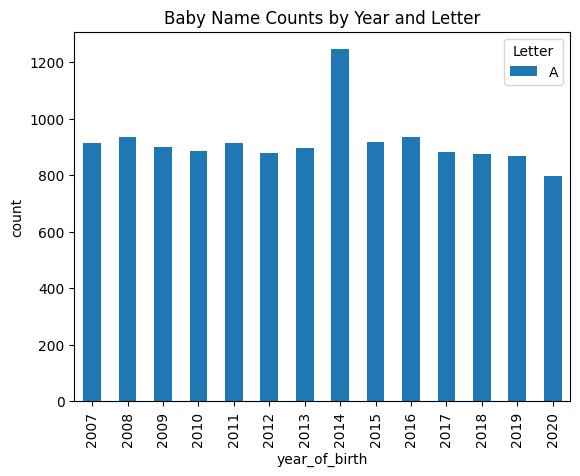

In [0]:
windowYearCount = (
    Window
    .partitionBy("year_of_birth")
    .orderBy(F.col("year_of_birth").asc(), F.col("count").desc())
)
#Aggregate to count first letter frequency per year
most_common_letter = (
    temp_df
    .select(
        F.substring("name", 0, 1).alias("first_letter"),
        F.col("year_of_birth"))
    .groupBy(
        "first_letter",
        "year_of_birth")
    .agg(
        F.count("*").alias("count"))
)

#get the most frequent letter per year
most_common_letter = (
    most_common_letter
    .withColumn("rank", F.dense_rank().over(windowYearCount))
    .where(F.col("rank")==1)
)

#Select only relevant columns
most_common_letter = (
    most_common_letter
    .select(
        "first_letter", 
        "year_of_birth",
        "count")
)

#convert to pandas to use matplot
pd_most_common_letter = most_common_letter.toPandas()

#Create simple bar chart
pivot_data = pd_most_common_letter.pivot(index='year_of_birth', columns='first_letter', values='count')

# Plot the bar chart
pivot_data.plot(kind='bar', stacked=True)
plt.xlabel('year_of_birth')
plt.ylabel('count')
plt.title('Baby Name Counts by Year and Letter')
plt.legend(title='Letter')
plt.show()